# Bayesian analyses and MCMC

## Defining priors

In [1]:
from likelihood import JointLikelihoodFunction, JointPriors
from equations import DM_EXT_model, Hubble, Modulus_sne

model = DM_EXT_model()
wCDM = Hubble()
mu_wCDM = Modulus_sne()

# Definindo os priors conjuntos
param_configs_constant = {
    'H_0': ((55, 91), 'uniform'),
    'Omega_m': ((0.26, 0.36), 'gaussian'),
    'A': ((55, 255), 'gaussian'),
    'beta': ((-5, 5), 'gaussian'),
    'omega_0': ((-2, 0), 'uniform')
}

param_configs_w0wa = {
    'H_0': ((55, 91), 'uniform'),
    'Omega_m': ((0.26, 0.36), 'gaussian'),
    'A': ((55, 255), 'gaussian'),
    'beta': ((-5, 5), 'gaussian'),
    'omega_0': ((-2, 0), 'uniform'),
    'omega_a': ((-2, 2), 'uniform')
}

P_constant = JointPriors(param_configs_constant)

P_w0wa = JointPriors(param_configs_w0wa)

# Creating an instance of JointLikelihoodFunction
LF_constant = JointLikelihoodFunction(
    { 'FRB': lambda z, H_0, Omega_m, A, beta, omega_0: model.DM_ext_th(
        z=z,
        f_IGM=0.83,
        model_type='constant',
        Omega_b=None,  
        Omega_m=Omega_m,     
        H_today=H_0,
        A=A,
        beta=beta,
        omega_0=omega_0,  
        cosmo_type='non_standard',
        param_type='constant'
    ), 

    'H(z)': lambda z, H_0, Omega_m, omega_0: wCDM.H_func(
        z=z,
        Omega_m=Omega_m,
        H_0=H_0,
        omega_0=omega_0,
        cosmo_type='non_standard',
        param_type='constant'
    ),

    'SNe': lambda z, H_0, Omega_m, omega_0: mu_wCDM.Modulo_std(
        z=z,
        Omega_m=Omega_m,
        H_0=H_0,
        omega_0=omega_0,
        cosmo_type='non_standard',
        param_type='constant'
    ) 
    }
)

LF_CPL = JointLikelihoodFunction(
    { 'FRB': lambda z, H_0, Omega_m, A, beta, omega_0, omega_a: model.DM_ext_th(
        z=z,
        f_IGM=0.83,
        model_type='constant',
        Omega_b=None,  
        Omega_m=Omega_m,     
        H_today=H_0,
        A=A,
        beta=beta,
        omega_0=omega_0,
        omega_a=omega_a,  
        cosmo_type='non_standard',
        param_type='CPL'
    ), 

    'H(z)': lambda z, H_0, Omega_m, omega_0, omega_a: wCDM.H_func(
        z=z,
        Omega_m=Omega_m,
        H_0=H_0,
        omega_0=omega_0,
        omega_a=omega_a,
        cosmo_type='non_standard',
        param_type='CPL'
    ),

    'SNe': lambda z, H_0, Omega_m, omega_0, omega_a: mu_wCDM.Modulo_std(
        z=z,
        Omega_m=Omega_m,
        H_0=H_0,
        omega_0=omega_0,
        omega_a=omega_a,
        cosmo_type='non_standard',
        param_type='CPL'
    ) 
    }
)

LF_BA = JointLikelihoodFunction(
    { 'FRB': lambda z, H_0, Omega_m, A, beta, omega_0, omega_a: model.DM_ext_th(
        z=z,
        f_IGM=0.83,
        model_type='constant',
        Omega_b=None,  
        Omega_m=Omega_m,     
        H_today=H_0,
        A=A,
        beta=beta,
        omega_0=omega_0,
        omega_a=omega_a,  
        cosmo_type='non_standard',
        param_type='BA'
    ), 

    'H(z)': lambda z, H_0, Omega_m, omega_0, omega_a: wCDM.H_func(
        z=z,
        Omega_m=Omega_m,
        H_0=H_0,
        omega_0=omega_0,
        omega_a=omega_a,
        cosmo_type='non_standard',
        param_type='BA'
    ),

    'SNe': lambda z, H_0, Omega_m, omega_0, omega_a: mu_wCDM.Modulo_std(
        z=z,
        Omega_m=Omega_m,
        H_0=H_0,
        omega_0=omega_0,
        omega_a=omega_a,
        cosmo_type='non_standard',
        param_type='BA'
    ) 
    }
)

## Preparing the samples

### Analysis for 16 FRBs

In [2]:
from obs_data import FRB_data, H_data, SNe_data
import ultranest

# Instantiate the FRB_data class for 16 FRBs
frb_data_16 = FRB_data(n_frb=16)

Hz_data = H_data()

sne_data = SNe_data(sample_sne='Pantheon+')

# Call the select_data method to get the observed data
z_obs_16, DM_obs_ext_16, DM_obs_ext_error_16 = frb_data_16.select_data()

z_obs_hz, H_obs, H_obs_error = Hz_data.H_z_data()

z_sne, mu_sne, cov_matrix = sne_data.load_data()

# Configuring the ultranest samplers
sampler_constant_16 = ultranest.ReactiveNestedSampler(
    P_constant.param_names,
    lambda params: LF_constant.log_likelihood(
        dict(zip(P_constant.param_names, params)),
        {
            'FRB': (z_obs_16, DM_obs_ext_16, DM_obs_ext_error_16),
            #'H(z)': (z_obs_hz, H_obs, H_obs_error),
            #'SNe': (z_sne, mu_sne, cov_matrix)
        }
    ),
    P_constant.prior_transform
)

sampler_CPL_16 = ultranest.ReactiveNestedSampler(
    P_w0wa.param_names,
    lambda params: LF_CPL.log_likelihood(
        dict(zip(P_w0wa.param_names, params)),
        {
            'FRB': (z_obs_16, DM_obs_ext_16, DM_obs_ext_error_16),
            #'H(z)': (z_obs_hz, H_obs, H_obs_error),
            #'SNe': (z_sne, mu_sne, cov_matrix)
        }
    ),
    P_w0wa.prior_transform
)

sampler_BA_16 = ultranest.ReactiveNestedSampler(
    P_w0wa.param_names,
    lambda params: LF_BA.log_likelihood(
        dict(zip(P_w0wa.param_names, params)),
        {
            'FRB': (z_obs_16, DM_obs_ext_16, DM_obs_ext_error_16),
            #'H(z)': (z_obs_hz, H_obs, H_obs_error),
            #'SNe': (z_sne, mu_sne, cov_matrix)
        }
    ),
    P_w0wa.prior_transform
)

/home/lazarolima/cosmology_reconstruction_frb/obs_data.py:145: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sne_data = pd.read_csv("data/Pantheon+SH0ES.dat", delim_whitespace=True)


### Analysis for 50 FRBs

In [3]:
"""# Instantiate the FRB_data class for 50 FRBs
frb_data_50 = FRB_data(n_frb=50)

# Call the select_data method to get the observed data
z_obs_50, DM_obs_ext_50, error_plus_50, error_minus_50 = frb_data_50.select_data()

z_values_50 = z_obs_50
dm_ext_obs_50 = DM_obs_ext_50
dm_error_plus_50 =  error_plus_50
dm_error_minus_50 =  error_minus_50

# Configuring the ultranest samplers
sampler_constant_50 = ultranest.ReactiveNestedSampler(
    P_constant.param_names,
    lambda params: LF_constant.log_likelihood(
        params,
        z_values=z_values_50,
        y_obs=dm_ext_obs_50,
        err_pos=error_plus_50,
        err_neg=error_minus_50
    ),
    P_constant.prior_transform
)

sampler_p2_50 = ultranest.ReactiveNestedSampler(
    P_p2.param_names,
    lambda params: LF_p2.log_likelihood(
        params,
        z_values=z_values_50,
        y_obs=dm_ext_obs_50,
        err_pos=error_plus_50,
        err_neg=error_minus_50
    ),
    P_p2.prior_transform
)

sampler_p3_50 = ultranest.ReactiveNestedSampler(
    P_p3.param_names,
    lambda params: LF_p3.log_likelihood(
        params,
        z_values=z_values_50,
        y_obs=dm_ext_obs_50,
        err_pos=error_plus_50,
        err_neg=error_minus_50
    ),
    P_p3.prior_transform
)"""

'# Instantiate the FRB_data class for 50 FRBs\nfrb_data_50 = FRB_data(n_frb=50)\n\n# Call the select_data method to get the observed data\nz_obs_50, DM_obs_ext_50, error_plus_50, error_minus_50 = frb_data_50.select_data()\n\nz_values_50 = z_obs_50\ndm_ext_obs_50 = DM_obs_ext_50\ndm_error_plus_50 =  error_plus_50\ndm_error_minus_50 =  error_minus_50\n\n# Configuring the ultranest samplers\nsampler_constant_50 = ultranest.ReactiveNestedSampler(\n    P_constant.param_names,\n    lambda params: LF_constant.log_likelihood(\n        params,\n        z_values=z_values_50,\n        y_obs=dm_ext_obs_50,\n        err_pos=error_plus_50,\n        err_neg=error_minus_50\n    ),\n    P_constant.prior_transform\n)\n\nsampler_p2_50 = ultranest.ReactiveNestedSampler(\n    P_p2.param_names,\n    lambda params: LF_p2.log_likelihood(\n        params,\n        z_values=z_values_50,\n        y_obs=dm_ext_obs_50,\n        err_pos=error_plus_50,\n        err_neg=error_minus_50\n    ),\n    P_p2.prior_transfor

### Analysis for 64 FRBs

In [4]:
# Instantiate the FRB_data class for 63 FRBs
frb_data_63 = FRB_data(n_frb=66)

# Call the select_data method to get the observed data
z_obs_63, DM_obs_ext_63, DM_obs_ext_error_63 = frb_data_63.select_data()

# Configuring the ultranest samplers
sampler_constant_63 = ultranest.ReactiveNestedSampler(
    P_constant.param_names,
    lambda params: LF_constant.log_likelihood(
        dict(zip(P_constant.param_names, params)),
        {
            'FRB': (z_obs_63, DM_obs_ext_63, DM_obs_ext_error_63),
            #'H(z)': (z_obs_hz, H_obs, H_obs_error),
            #'SNe': (z_sne, mu_sne, cov_matrix)
        }
    ),
    P_constant.prior_transform
)

sampler_CPL_63 = ultranest.ReactiveNestedSampler(
    P_w0wa.param_names,
    lambda params: LF_CPL.log_likelihood(
        dict(zip(P_w0wa.param_names, params)),
        {
            'FRB': (z_obs_63, DM_obs_ext_63, DM_obs_ext_error_63),
            #'H(z)': (z_obs_hz, H_obs, H_obs_error),
            #'SNe': (z_sne, mu_sne, cov_matrix)
        }
    ),
    P_w0wa.prior_transform
)

sampler_BA_63 = ultranest.ReactiveNestedSampler(
    P_w0wa.param_names,
    lambda params: LF_BA.log_likelihood(
        dict(zip(P_w0wa.param_names, params)),
        {
            'FRB': (z_obs_63, DM_obs_ext_63, DM_obs_ext_error_63),
            #'H(z)': (z_obs_hz, H_obs, H_obs_error),
            #'SNe': (z_sne, mu_sne, cov_matrix)
        }
    ),
    P_w0wa.prior_transform
)

In [5]:
wCDM_16 = sampler_constant_16.run(min_num_live_points=400)
sampler_constant_16.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  9 [-4.6246..-4.6245]*| it/evals=2615/8192 eff=33.5601% N=400 0 
[ultranest] Likelihood function evaluations: 8211
[ultranest]   logZ = -6.555 +- 0.04145
[ultranest] Effective samples strategy satisfied (ESS = 1362.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)
[ultranest]   logZ error budget: single: 0.05 bs:0.04 tail:0.01 total:0.04 required:<0.50
[ultranest] done iterating.

logZ = -6.562 +- 0.090
  single instance: logZ = -6.562 +- 0.055
  bootstrapped   : logZ = -6.555 +- 0.089
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H_0                 : 55.0  │▇▆▇▆▆▇▇▆▅▆▅▄▄▄▅▅▅▄▃▄▄▂▃▃▃▁▂▂▂▂▁▁▁▁▁▁▁▁▁│91.0      66.2 +- 8.0
    Omega_m             : 0.254 │ ▁▁▁▁▁▂▁▂▂▃▃▄▆▆▆▇▇▇▇▇▇▇▆▆▅▅▃▃▂▂▁▁▁▁▁▁▁ │0.366     0.310 +- 0.017
    A                   : 59    │ ▁▁▁▁▁▁▁▂▃▄▃▄

In [6]:
wCDM_63 = sampler_constant_63.run(min_num_live_points=400)
sampler_constant_63.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8e+01   [-77.9395..-77.9393]*| it/evals=3588/13086 eff=28.2831% N=400 
[ultranest] Likelihood function evaluations: 13102
[ultranest]   logZ = -82.24 +- 0.06075
[ultranest] Effective samples strategy satisfied (ESS = 2097.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)
[ultranest]   logZ error budget: single: 0.08 bs:0.06 tail:0.01 total:0.06 required:<0.50
[ultranest] done iterating.

logZ = -82.243 +- 0.142
  single instance: logZ = -82.243 +- 0.077
  bootstrapped   : logZ = -82.240 +- 0.141
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H_0                 : 55.0  │▂▁▂▂▁▁▂▃▂▂▂▃▂▃▃▃▄▄▄▄▄▅▄▅▄▆▄▅▆▆▆▆▆▇▆▇▅▆▇│91.0      78.0 +- 9.1
    Omega_m             : 0.249 │ ▁▁▁▁▁▁▁▁▁▃▃▃▄▅▅▆▇▇▇▇▅▄▄▄▂▃▂▁▁▁▁▁▁▁  ▁ │0.378     0.310 +- 0.016
    A                   : 66    │ ▁   

In [7]:
CPL_16 = sampler_CPL_16.run(min_num_live_points=400)
sampler_CPL_16.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  8 [-4.6316..-4.6316]*| it/evals=2600/8473 eff=32.2061% N=400 0 
[ultranest] Likelihood function evaluations: 8480
[ultranest]   logZ = -6.513 +- 0.04084
[ultranest] Effective samples strategy satisfied (ESS = 1358.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)
[ultranest]   logZ error budget: single: 0.05 bs:0.04 tail:0.01 total:0.04 required:<0.50
[ultranest] done iterating.

logZ = -6.515 +- 0.093
  single instance: logZ = -6.515 +- 0.054
  bootstrapped   : logZ = -6.513 +- 0.093
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H_0                 : 55.0  │▇▇▆▆▇▇▆▆▇▄▅▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁│91.0      66.0 +- 8.1
    Omega_m             : 0.253 │ ▁ ▁▁▁▁▂▃▂▂▃▄▅▆▆▇▇▆▆▅▅▄▄▃▂▂▂▂▁▁▁▁ ▁  ▁ │0.378     0.311 +- 0.017
    A                   : 34    │ ▁ ▁  ▁▁▁▁▂▂▂

In [8]:
CPL_63 = sampler_CPL_63.run(min_num_live_points=400)
sampler_CPL_63.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8e+01   [-77.9739..-77.9739]*| it/evals=3615/17441 eff=21.2135% N=400 
[ultranest] Likelihood function evaluations: 17441
[ultranest]   logZ = -82.32 +- 0.05633
[ultranest] Effective samples strategy satisfied (ESS = 2089.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)
[ultranest]   logZ error budget: single: 0.08 bs:0.06 tail:0.01 total:0.06 required:<0.50
[ultranest] done iterating.

logZ = -82.320 +- 0.131
  single instance: logZ = -82.320 +- 0.077
  bootstrapped   : logZ = -82.320 +- 0.130
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H_0                 : 55.0  │▂▁▁▂▂▂▃▃▃▃▄▃▃▃▄▃▃▄▄▄▅▄▆▄▆▅▆▅▅▆▆▆▆▆▇▆▆▇▇│91.0      77.5 +- 9.3
    Omega_m             : 0.251 │ ▁▁▁▁▁▁▁▁▂▂▃▅▅▅▆▇▇▇▇▆▅▅▅▄▄▃▁▂▁▁▁▁▁▁  ▁ │0.377     0.310 +- 0.017
    A                   : 78    │ ▁  ▁

In [9]:
BA_16 = sampler_BA_16.run(min_num_live_points=400)
sampler_BA_16.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5  7 [-4.6287..-4.6286]*| it/evals=2560/8794 eff=30.4980% N=400  
[ultranest] Likelihood function evaluations: 8798
[ultranest]   logZ = -6.404 +- 0.03941
[ultranest] Effective samples strategy satisfied (ESS = 1320.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)
[ultranest]   logZ error budget: single: 0.05 bs:0.04 tail:0.01 total:0.04 required:<0.50
[ultranest] done iterating.

logZ = -6.408 +- 0.073
  single instance: logZ = -6.408 +- 0.052
  bootstrapped   : logZ = -6.404 +- 0.072
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H_0                 : 55.0  │▇▇▇▇▇▆▆▆▅▆▆▆▇▆▄▄▃▄▄▃▄▃▄▂▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁│91.0      66.0 +- 8.0
    Omega_m             : 0.247 │ ▁▁ ▁▁▁▁▁▁▂▂▃▅▄▆▇▇▇▇▆▇▄▅▄▃▃▃▂▁▁▁▁ ▁▁▁▁ │0.374     0.310 +- 0.017
    A                   : 42    │ ▁  ▁▁▁▁▁▂▃▃▄▅

In [10]:
BA_63 = sampler_BA_63.run(min_num_live_points=400)
sampler_BA_63.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8e+01   [-78.0113..-78.0113]*| it/evals=3610/21923 eff=16.7728% N=400 
[ultranest] Likelihood function evaluations: 21939
[ultranest]   logZ = -82.32 +- 0.07117
[ultranest] Effective samples strategy satisfied (ESS = 2085.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.08 bs:0.07 tail:0.01 total:0.07 required:<0.50
[ultranest] done iterating.

logZ = -82.336 +- 0.195
  single instance: logZ = -82.336 +- 0.076
  bootstrapped   : logZ = -82.323 +- 0.194
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H_0                 : 55.0  │▁▂▂▂▁▂▂▃▂▂▂▄▄▄▃▄▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▆▆▆▇▆▆▆│91.0      77.5 +- 9.1
    Omega_m             : 0.244 │ ▁  ▁▁▁▁▁▁▂▂▂▄▅▅▆▆▇▇▆▆▆▆▆▅▄▃▂▂▁▁▁▁▁▁ ▁ │0.372     0.310 +- 0.017
    A                   : 76    │ ▁▁ ▁

In [11]:
from getdist import plots, MCSamples

# Extraindo amostras dos resultados
samples1_16 = wCDM_16['samples']
samples2_16 = CPL_16['samples']
samples3_16 = BA_16['samples']

samples1_63 = wCDM_63['samples']
samples2_63 = CPL_63['samples']
samples3_63 = BA_63['samples']

# Criando objetos MCSamples com os dados
#labels1 = P_constant.param_names
labels1 = ['H_0', '\\Omega_m', 'A', '\\beta', '\\omega_0']
names1 = P_constant.param_names
mcsamples1_16 = MCSamples(samples=samples1_16, names=names1, labels=labels1)
#mcsamples1_50 = MCSamples(samples=samples1_50, names=names1, labels=labels1)
mcsamples1_63 = MCSamples(samples=samples1_63, names=names1, labels=labels1)

labels2 = ['H_0', '\\Omega_m', 'A', '\\beta', '\\omega_0', '\\omega_a']
names2 = P_w0wa.param_names
mcsamples2_16 = MCSamples(samples=samples2_16, names=names2, labels=labels2)
#mcsamples2_50 = MCSamples(samples=samples2_50, names=names2, labels=labels2)
mcsamples2_63 = MCSamples(samples=samples2_63, names=names2, labels=labels2)

mcsamples3_16 = MCSamples(samples=samples3_16, names=names2, labels=labels2)
#mcsamples3_50 = MCSamples(samples=samples3_50, names=names2, labels=labels2)
mcsamples3_63 = MCSamples(samples=samples3_63, names=names2, labels=labels2)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


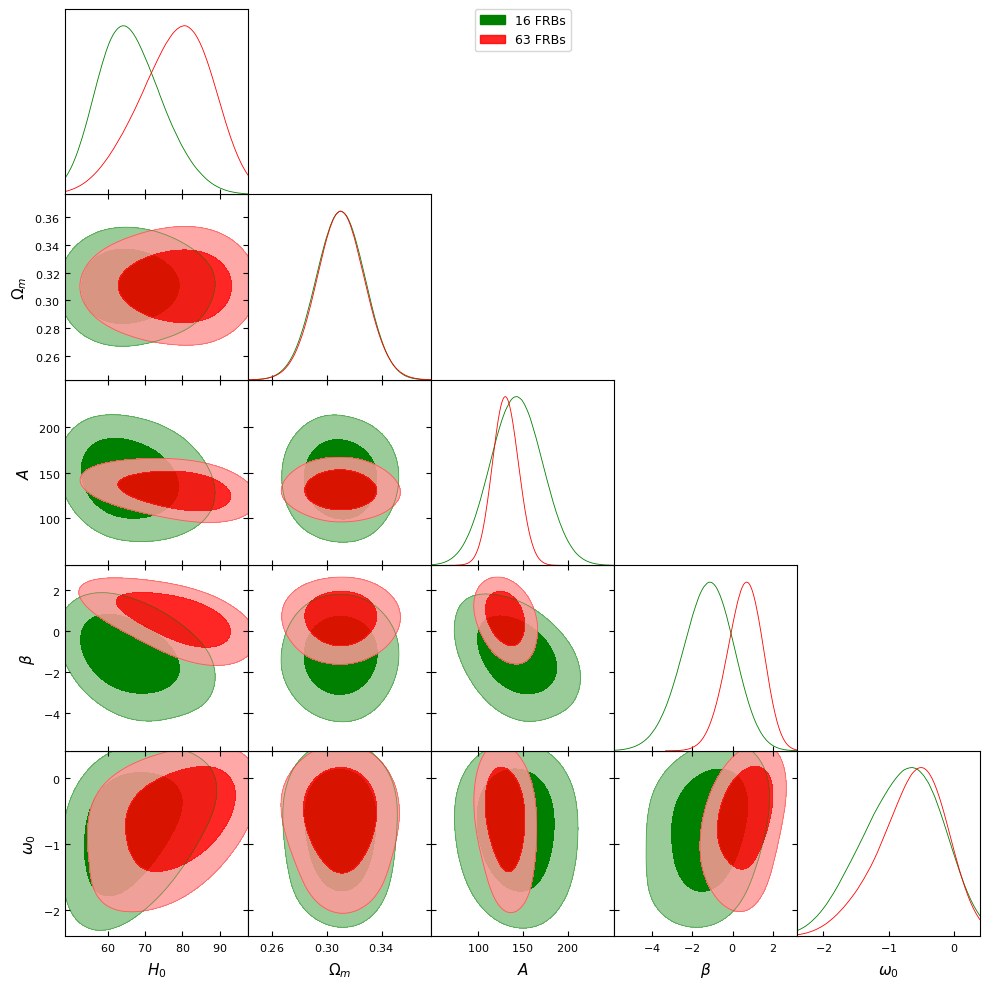

In [12]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples1_16.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
mcsamples1_63.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot([mcsamples1_16, mcsamples1_63], filled=True, contour_colors=['green', 'red'], 
                legend_labels=['16 FRBs', '63 FRBs'])
g.export('Figuras/param_constant_frb.png', dpi=600)

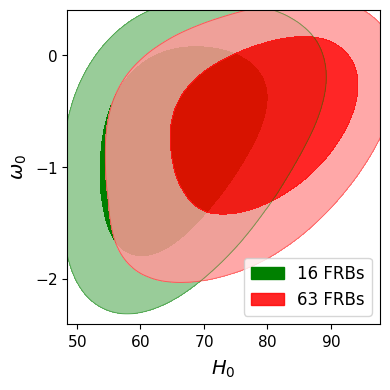

In [13]:
# Filled 2D comparison plot with legend
g = plots.get_single_plotter(width_inch=4, ratio=1)
g.plot_2d([mcsamples1_16, mcsamples1_63], 'H_0', 'omega_0', filled=True, colors=['green', 'red'])
g.add_legend(['16 FRBs', '63 FRBs'], legend_loc='lower right')
g.export('Figuras/param_constant_frb_w0_H0.png', dpi=600)

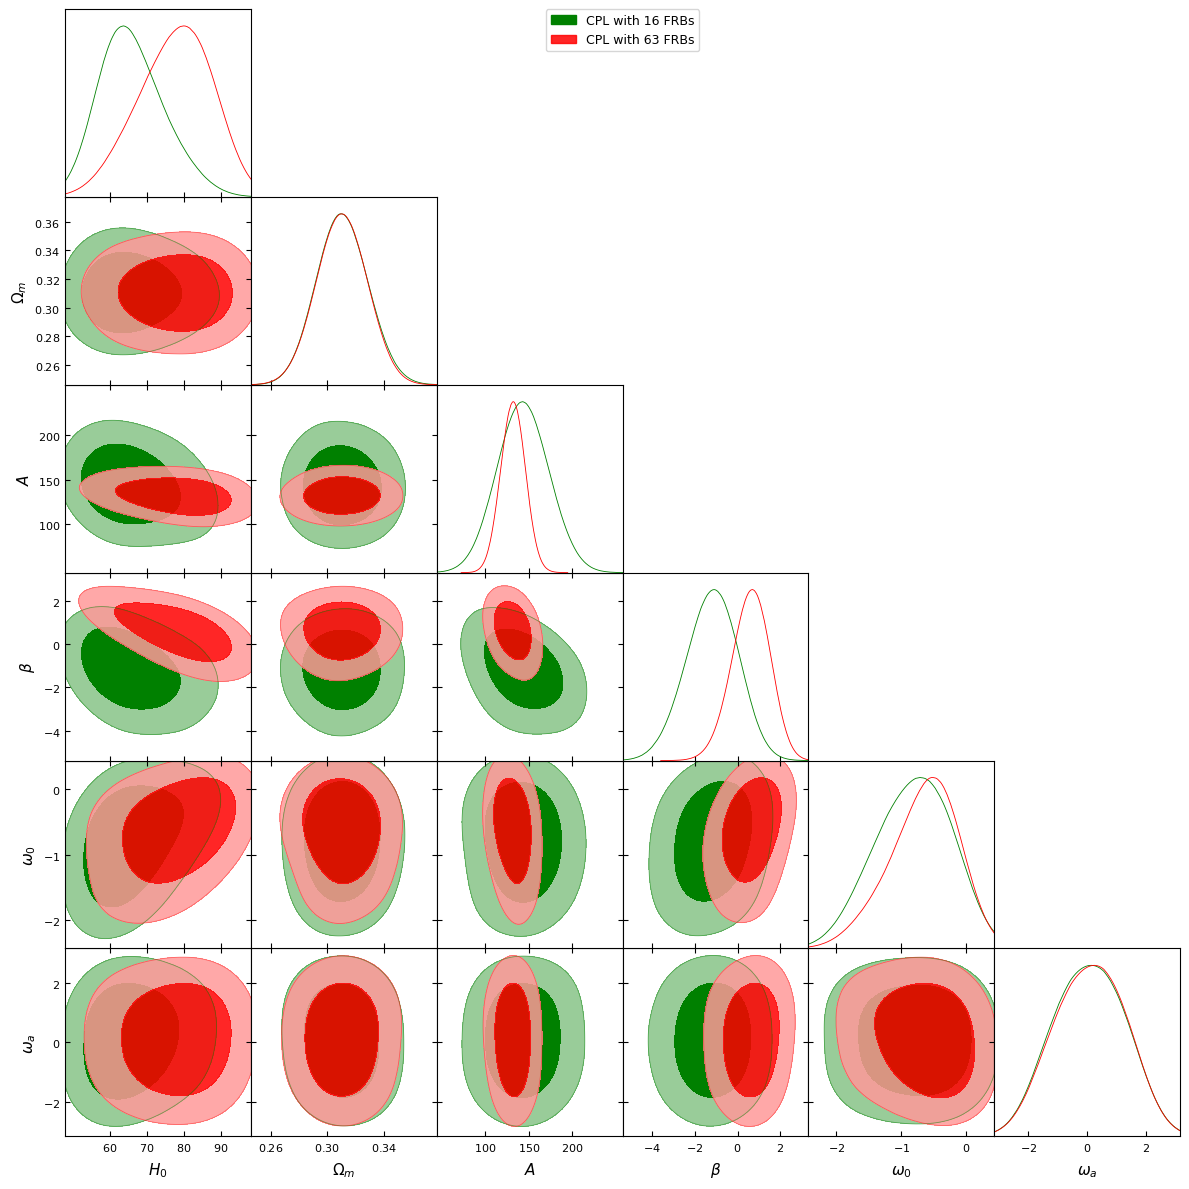

In [14]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples2_16.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
mcsamples2_63.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot([mcsamples2_16, mcsamples2_63], filled=True, contour_colors=['green', 'red'], 
                legend_labels=['CPL with 16 FRBs', 'CPL with 63 FRBs'],) 
                #title_limit=1)
g.export('Figuras/param_CPL_frb.png', dpi=600)

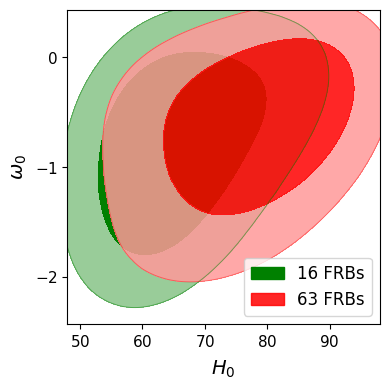

In [15]:
# Filled 2D comparison plot with legend
g = plots.get_single_plotter(width_inch=4, ratio=1)
g.plot_2d([mcsamples2_16, mcsamples2_63], 'H_0', 'omega_0', filled=True, colors=['green', 'red'])
g.add_legend(['16 FRBs', '63 FRBs'], legend_loc='lower right')
g.export('Figuras/param_CPL_frb_w0_H0.png', dpi=600)

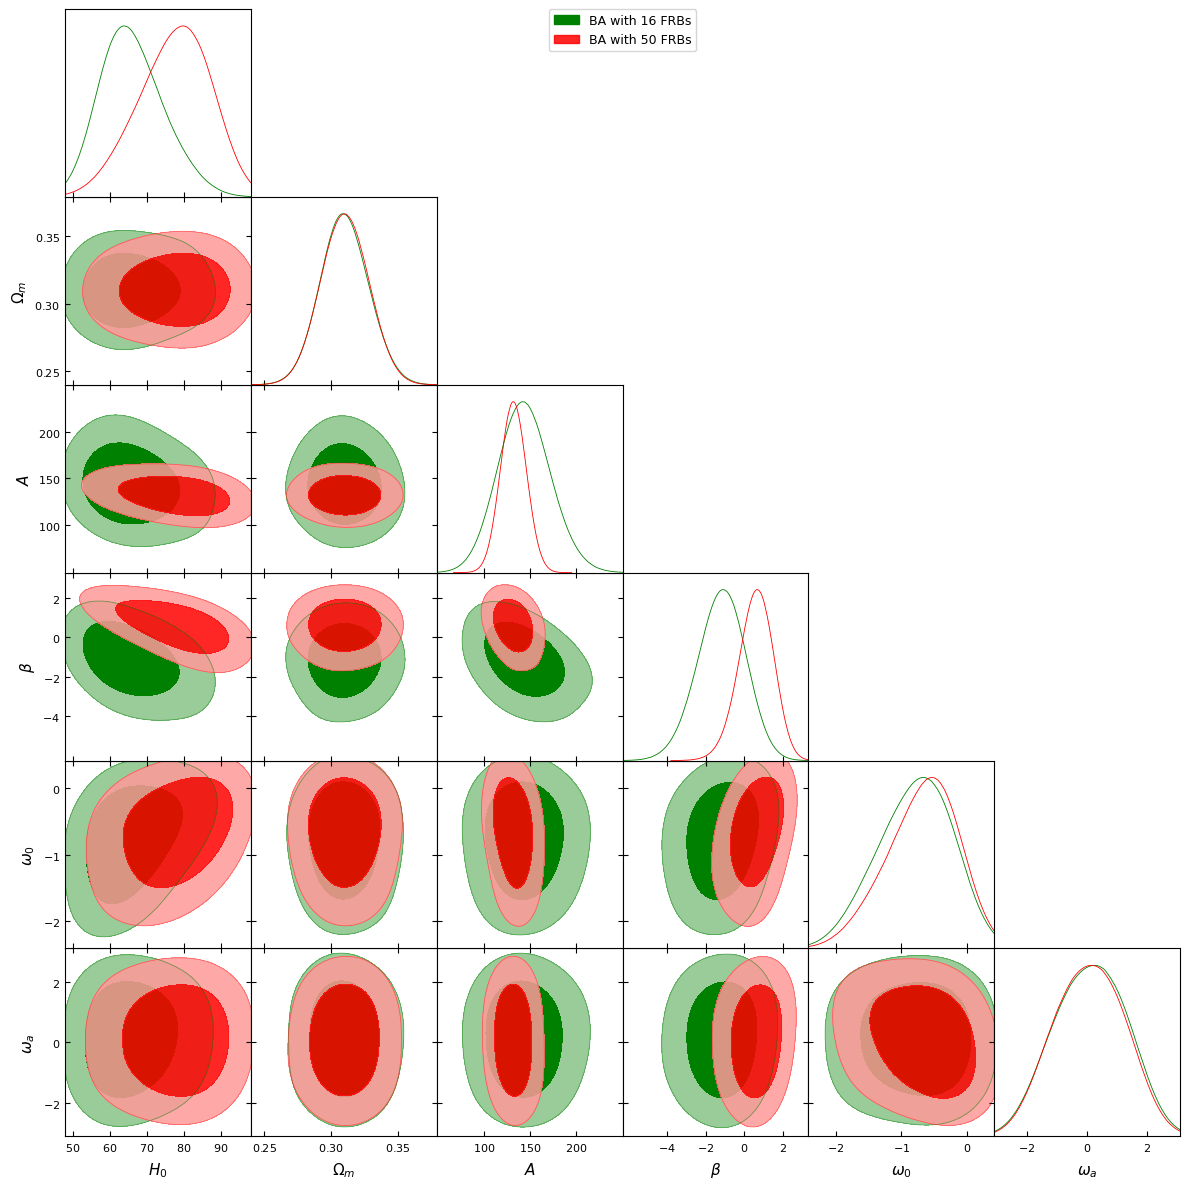

In [16]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples3_16.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
mcsamples3_63.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot([mcsamples3_16, mcsamples3_63], filled=True, contour_colors=['green', 'red'], 
                legend_labels=['BA with 16 FRBs', 'BA with 50 FRBs'],)
                #title_limit=1)
g.export('Figuras/param_BA_frb.png', dpi=600)

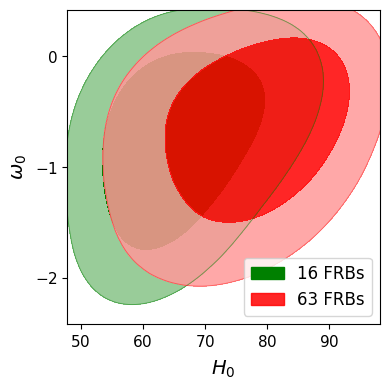

In [17]:
# Filled 2D comparison plot with legend
g = plots.get_single_plotter(width_inch=4, ratio=1)
g.plot_2d([mcsamples3_16, mcsamples3_63], 'H_0', 'omega_0', filled=True, colors=['green', 'red'])
g.add_legend(['16 FRBs', '63 FRBs'], legend_loc='lower right')
g.export('Figuras/param_BA_frb_w0_H0.png', dpi=600)

## Model Comparison

In [20]:
results_16 = {
    'wCDM': {'samples': samples1_16, 'logz': wCDM_16['logz'], 'num_params': 5},
    'CPL': {'samples': samples2_16, 'logz': CPL_16['logz'], 'num_params': 6},
    'BA': {'samples': samples3_16, 'logz': BA_16['logz'], 'num_params': 6}
}

results_63 = {
    'wCDM': {'samples': samples1_63, 'logz': wCDM_63['logz'], 'num_params': 5},
    'CPL': {'samples': samples2_63, 'logz': CPL_63['logz'], 'num_params': 6},
    'BA': {'samples': samples3_63, 'logz': BA_63['logz'], 'num_params': 6}
}


In [21]:
from bayesian_analysis import ModelComparison

comparison = ModelComparison(results_16, results_63)
comparison.run_comparisons(n_data_16=16, n_data_63=66, save_to_file='comparisons_output.txt')


In [ ]:
from ultranest.plot import PredictionBand
from equations import DM_EXT_model
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.xlabel('$z$')
plt.ylabel('$DM_{ext}(z)$')
plt.errorbar(x=z_values_16, y=dm_ext_obs_16, fmt='o', alpha=0.6, color='red', label='16 FRBs', ms=2)

z_test = np.linspace(0, 1, 100)

band = PredictionBand(z_test)
model_fit = DM_EXT_model()
# go through the solutions
for H_0, A, beta, omega_0, omega_a  in sampler_p2_16.results['samples']:
    # compute for each time the y value
    band.add(model_fit.DM_ext_th(z=z_test,
        f_IGM=0.83,
        model_type='constant',
        Omega_b=None,  
        Omega_m=None,     
        H_today=H_0,
        A=A,
        beta=beta,
        omega_0=omega_0,  
        omega_a=omega_a,
        cosmo_type='non_standard',
        param_type='CPL'))

band.line(color='k', linestyle='-', label='CPL parameterization', linewidth=1.5)
# add 1 sigma quantile
band.shade(color='green', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='green', alpha=0.2)

plt.legend()
plt.savefig('Figuras/DM_ext_bestfit_16.png', format='png', dpi=600)

In [ ]:
from ultranest.plot import PredictionBand
from equations import DM_EXT_model
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.xlabel('$z$')
plt.ylabel('$DM_{ext}(z)$')
plt.errorbar(x=z_values_63, y=dm_ext_obs_63, fmt='o', alpha=0.6, color='red', label='63 FRBs', ms=2)

z_test = np.linspace(0, 1.1, 100)

band = PredictionBand(z_test)
model_fit = DM_EXT_model()
# go through the solutions
for H_0, A, beta, omega_0  in sampler_constant_63.results['samples']:
    # compute for each time the y value
    band.add(model_fit.DM_ext_th(z=z_test,
        f_IGM=0.83,
        model_type='constant',
        Omega_b=None,  
        Omega_m=None,     
        H_today=H_0,
        A=A,
        beta=beta,
        omega_0=omega_0,
        cosmo_type='non_standard',
        param_type='constant')
    )

band.line(color='k', linestyle='-', label='Constant parameterization', linewidth=1.5)
# add 1 sigma quantile
band.shade(color='green', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='green', alpha=0.2)

plt.legend()
plt.savefig('Figuras/DM_ext_bestfit_63.png', format='png', dpi=600)